In [2]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import pickle
from datetime import datetime

from sklearn.metrics import f1_score
from tensorflow.keras import backend as K
from pymagnitude import Magnitude

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

tf.random.set_seed(1234)
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Save dataset leaving top 10 classes

In [3]:
MAX_NUM_WORDS = 1000
WORD_DIMENTIONS = 64
MAX_TEXT_LENGTH = 100
TOP_NUM = 10

In [38]:
# load reuters dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=MAX_NUM_WORDS) 
# get dictionary with all words in dataset
word_index = tf.keras.datasets.reuters.get_word_index()

keys = tuple(word_index.keys())
values = tuple(word_index.values())

In [5]:
# leaving most large 10 classes
x_tn, y_tn, x_tt, y_tt = [], [], [], []

elements_count = collections.Counter(y_train)
elements_count = {k: v for k, v in sorted(elements_count.items(), key=lambda item: item[1], reverse=True)}
topN = list(elements_count.keys())[:TOP_NUM]

for index, y in enumerate(y_train):
    if y in topN:
        x_tn.append(x_train[index])
        y_tn.append(topN.index(y))

for index, y in enumerate(y_test):
    if y in topN:
        x_tt.append(x_test[index])
        y_tt.append(topN.index(y))

### Write dataset as pickle to file

In [6]:
x_trn, x_tst = [], []

In [7]:
for text in x_tn:
    x_trn.append([keys[values.index(word)] for word in text])

with open('./datasets/x_train.pkl', "wb") as out:
    pickle.dump(x_trn, out)

with open('./datasets/y_train.pkl', "wb") as out:
    pickle.dump(y_tn, out)

In [8]:
for text in x_tt:
    x_tst.append([keys[values.index(word)] for word in text])

with open('./datasets/x_test.pkl', "wb") as out:
    pickle.dump(x_tst, out)

with open('./datasets/y_test.pkl', "wb") as out:
    pickle.dump(y_tt, out)

# Write embedded dataset to file

In [2]:
def write_emb(data, e_name, f_name):
    emb = Magnitude(f'{e_name}.magnitude')

    emb_repr = [(np.mean(emb.query(text), axis=0)).tolist() for text in data]

    with open(f'./datasets/x_{f_name}_{e_name}.pkl', "wb") as out:
        pickle.dump(emb_repr, out)

In [3]:
with open('./datasets/x_test.pkl', "rb") as file:
    data = pickle.load(file)

print(data[0])

for e_name in ['glove', 'fasttext', 'word2vec']:
    write_emb(data, e_name, 'test')

['the', 'in', 'of', 'of', '3', 'how', 'of', 'could', 'mln', 'at', 'against', '2', 'of', 'vs', 'end', 'products', 'opec', 'he', 'will', 'will', 'of', 'results', 'and', 'of', 'exports', '3', 'of', 'each', 'it', 'of', 'profit', '3', 'of', 'profit', 'agreement', 'in', 'around', 'corp', 'should', 'for', '3', 'of', 'mln', 'in', 'ended', 'said', 'of', 'a', '54', 'but', '3', 'of', 'a', 'only', 'of', 'political', 'of', 'date', 'other', 'under', 'well', 'a', 'in', 'british', 'rate', 'gain', 'if', 'demand', 'at', 'an', 'div', 'its', 'taking', 'report', 'of', 'systems', 'were', 'is', 'and', 'production', 'had', 'vs', '000', '7', 'issued', 'year', 'for', '0', 'a', 'in', 'buffer', 'rate', 'loss', 'may', 'results', 'tariffs', 'dlrs', 'is', 'and', 'from', '39', 's', '000', 'for', '3', 'of', 'pre', '50', 'east', 'that', 'in', 'of', 'products', 'opec', 'last', '1', 'fall', 'change', '1', 'approval', 'in', '15', '2', 'said', 'in', 'opec', '28', 'but', 'for', '3', 'of', 'cts', 'systems', 'which', 'is', 'h

In [4]:
with open('./datasets/x_train.pkl', "rb") as file:
    data = pickle.load(file)

print(data[0])

for e_name in ['glove', 'fasttext', 'word2vec']:
    write_emb(data, e_name, 'train')

['the', 'of', 'of', 'mln', 'loss', 'for', 'plc', 'said', 'at', 'only', 'ended', 'said', 'of', 'could', '1', 'traders', 'now', 'april', '0', 'a', 'after', 'said', 'from', '1985', 'and', 'from', 'foreign', '000', 'april', '0', 'prices', 'its', 'account', 'year', 'a', 'but', 'in', 'this', 'mln', 'home', 'an', 'states', 'earlier', 'and', 'rise', 'and', 'revs', 'vs', '000', 'its', '16', 'vs', '000', 'a', 'but', '3', 'of', 'of', 'several', 'and', 'shareholders', 'and', 'dividend', 'vs', '000', 'its', 'all', '4', 'vs', '000', '1', 'mln', 'agreed', 'of', 'april', '0', 'are', '2', 'states', 'will', 'billion', 'total', 'and', 'against', '000', 'pct', 'dlrs']


In [64]:
# Read embedded data
def get_emb_data(name, emb_name):
    with open(f'./datasets/x_{name}_{emb_name}.pkl', "rb") as file:
        data = pickle.load(file)
    return data

#Read labels data
def get_y_data(name):
    with open(f'./datasets/y_{name}.pkl', "rb") as file:
        data = pickle.load(file)
    return data

In [65]:
# Class LSTM from previous task
class LSTM(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LSTM, self).__init__()
        self.units = units
        
    def build(self, input_shape):   
        self.w_input_gate = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.w_input_hidden = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.b_input = self.add_weight(shape=(self.units,), initializer="zeros")

        self.w_forget_gate = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.w_forget_hidden = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.b_forget = self.add_weight(shape=(self.units,), initializer="zeros")

        self.w_output_gate = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.w_output_hidden = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.b_output = self.add_weight(shape=(self.units,), initializer="zeros")

        self.w_memory_cell = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.w_memory_cell_hidden = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.b_memory_cell = self.add_weight(shape=(self.units,), initializer="zeros")
    
    def call(self, inputs):    
        initial_states = tf.keras.backend.zeros_like(inputs)
        initial_states = tf.keras.backend.sum(initial_states, axis=(1, 2))
        initial_states = tf.keras.backend.expand_dims(initial_states)
        initial_states = [tf.keras.backend.tile(initial_states, [1, self.units]),
               tf.keras.backend.tile(initial_states, [1, self.units])]

        input_length = tf.keras.backend.int_shape(inputs)[1]

        last_output, outputs, new_states = tf.keras.backend.rnn(step_function=self._step, inputs=inputs, initial_states=initial_states, input_length=input_length)
        return last_output

    def _step(self, inputs, states):
        input_gate = tf.sigmoid(tf.keras.backend.dot(inputs, self.w_input_gate) + tf.keras.backend.dot(states[0], self.w_input_hidden) + self.b_input)
        forget_gate = tf.sigmoid(tf.keras.backend.dot(inputs, self.w_forget_gate) + tf.keras.backend.dot(states[0], self.w_forget_hidden) + self.b_forget)
        output_gate = tf.sigmoid(tf.keras.backend.dot(inputs, self.w_output_gate) + tf.keras.backend.dot(states[0], self.w_output_hidden) + self.b_output)
        memory_cell = tf.tanh(tf.keras.backend.dot(inputs, self.w_memory_cell) + tf.keras.backend.dot(states[0], self.w_memory_cell_hidden) + self.b_memory_cell)
        
        state = forget_gate * states[1] + input_gate * memory_cell
        new_output = output_gate * tf.tanh(state)
        
        return new_output, [states[0], state] 

# Class RNN from previous task
class RNN(tf.keras.layers.Layer):
    def __init__(self, units):
        super(RNN, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.u = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.w = self.add_weight(shape=(self.units, self.units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='zeros')

    def call(self, inputs):
        initial_states = tf.keras.backend.zeros_like(inputs)
        initial_states = tf.keras.backend.sum(initial_states, axis=(1,2))
        initial_states = tf.keras.backend.expand_dims(initial_states)
        initial_states = [tf.keras.backend.tile(initial_states, [1, self.units])]

        input_length = tf.keras.backend.int_shape(inputs)[1]

        last_output, outputs, new_states = tf.keras.backend.rnn(step_function=self._step, inputs=inputs, initial_states=initial_states, input_length=input_length)

        return last_output

    def _step(self, inputs, states):
        new_output = tf.keras.backend.dot(inputs, self.u) + tf.keras.backend.dot(states[0], self.w) + self.b
        return new_output, [new_output]

# Task 1 results

In [84]:
def draw(data, metrics, model):
    plt.figure(figsize=(20,10))
    plt.title(f'{model} {metrics}')
    max_epochs = len(data.history[metrics])+1
    x = range(1, max_epochs)
    plt.plot(x, data.history[metrics])
    plt.plot(x, data.history[f'val_{metrics}'])
    plt.xticks(np.arange(1, max_epochs))
    plt.ylabel(metrics)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def draw_multiple(data, metrics, model):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()

    plt.title(f'{model} {metrics}')
    plt.xlabel('Epoch')
    plt.ylabel(metrics)

    max_epochs = len(data[0].history[metrics])+1
    x = range(1, max_epochs)
    plt.xticks(np.arange(1, max_epochs))

    for i, d in enumerate(['glove', 'fasttext', 'word2vec']):
        plt.plot(x, data[i].history[metrics], label=f'train, embedding = {d}')
        plt.plot(x, data[i].history[f'val_{metrics}'], label=f'test, embedding = {d}')
    plt.legend()
    plt.show()

In [127]:
#Test for models trained on embedded data

hs = []

for i in ['glove', 'fasttext', 'word2vec']:
    x_train = get_emb_data('train', i)
    y_train = get_y_data('train')

    x_test = get_emb_data('test', i)
    y_test = get_y_data('test')

    model = None
    
    model = tf.keras.Sequential([
        RNN(32),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.01),
                    metrics=['accuracy'])

    hs.append(model.fit(np.expand_dims(x_train,1), np.expand_dims(y_train,1), epochs=10, validation_data=(np.expand_dims(x_test,1), np.expand_dims(y_test,1)), batch_size=64))

Epoch 1/10
120/120 [==============================] - 1s 6ms/step - loss: 1.3884 - accuracy: 0.5608 - val_loss: 1.2019 - val_accuracy: 0.6440
Epoch 2/10
120/120 [==============================] - 1s 5ms/step - loss: 1.1400 - accuracy: 0.6313 - val_loss: 1.0567 - val_accuracy: 0.6759
Epoch 3/10
120/120 [==============================] - 1s 5ms/step - loss: 1.0129 - accuracy: 0.6844 - val_loss: 0.9882 - val_accuracy: 0.7109
Epoch 4/10
120/120 [==============================] - 1s 5ms/step - loss: 0.9183 - accuracy: 0.7310 - val_loss: 0.9027 - val_accuracy: 0.7471
Epoch 5/10
120/120 [==============================] - 1s 5ms/step - loss: 0.8379 - accuracy: 0.7605 - val_loss: 0.8722 - val_accuracy: 0.7434
Epoch 6/10
120/120 [==============================] - 1s 5ms/step - loss: 0.7826 - accuracy: 0.7779 - val_loss: 0.8622 - val_accuracy: 0.7683
Epoch 7/10
120/120 [==============================] - 1s 5ms/step - loss: 0.7485 - accuracy: 0.7888 - val_loss: 0.7910 - val_accuracy: 0.7821
Epoch 

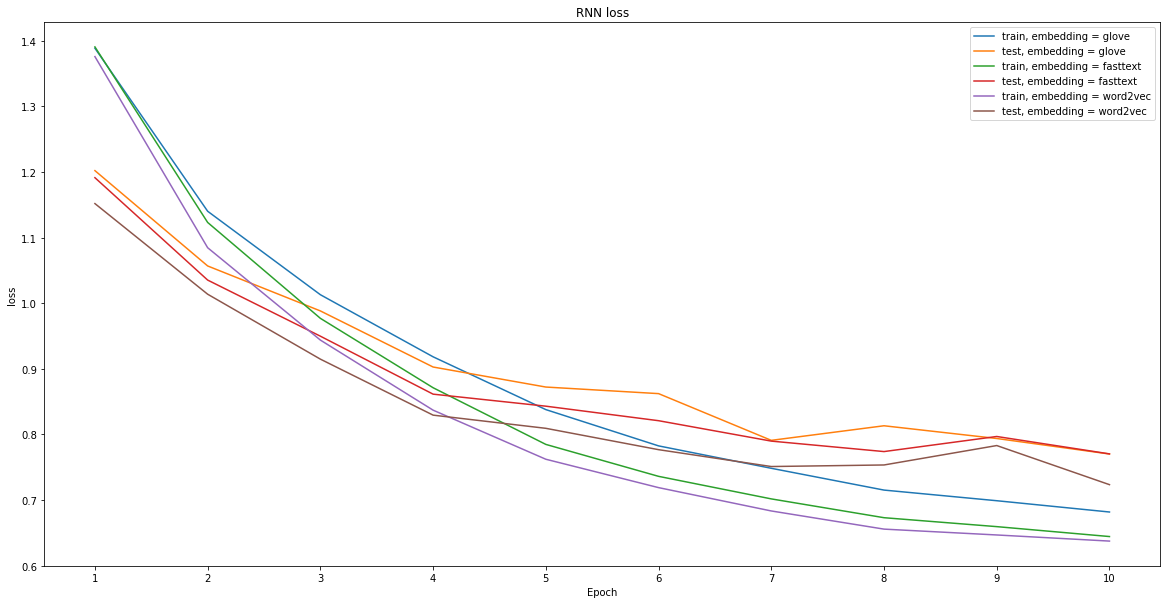

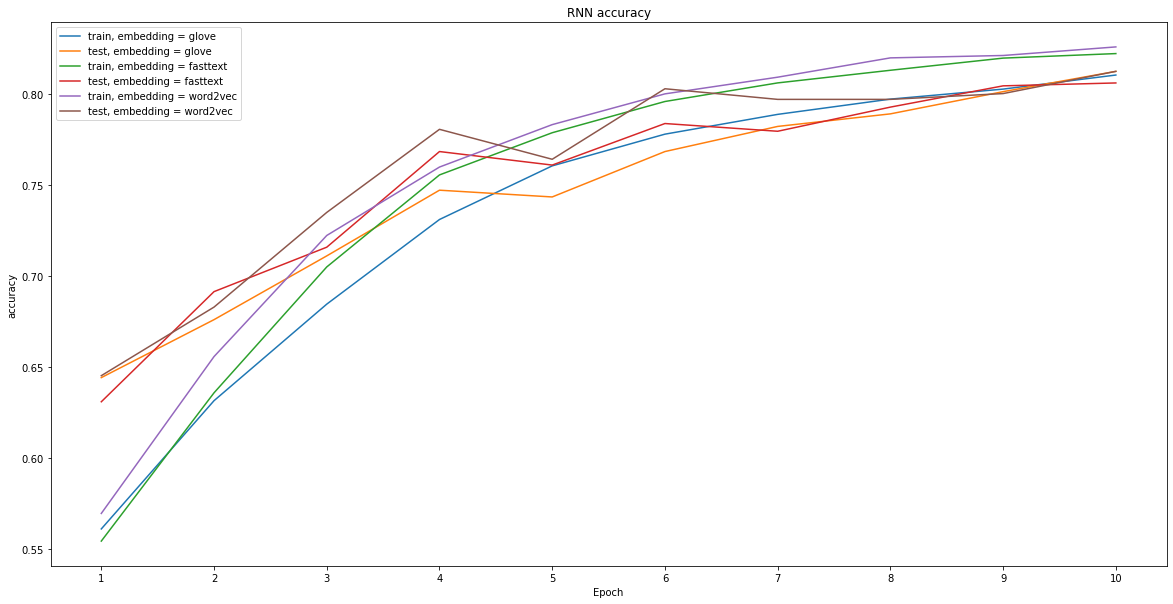

In [128]:
draw_multiple(hs, 'loss', 'RNN')
draw_multiple(hs, 'accuracy', 'RNN')

# Wnioski

Wyuczono 3 modele RNN na zbiorze danych tensorflow.reuters, osadzonym wektorowo różnymi modelami: Glove, FastText i Word2Vec. Modele wektorów osadzenia zostały zaimportowane za pomocą biblioteki pyMagnitude.

Na powyższych wykresach można zauważyć, że max wyniki acc na zbiorze testowym osiągnęły sieci uczone na danych osadzonych wektorowo modelami Glove oraz Word2Vec i wynoszą ~81.2%. Wynik sieci FastText jest nieznacząco gorszy i wynosi 80.6%. 

Wyniki funkcji straty nie wiele czym się różnią pomiędzy sieciami. Maksymalnie niski wynik osiągnęła sieć Word2Vec - 0.72 na zbiorze testowym. Wynik f. loss sieci uczonych na zbiorach Glove i Fasttext jest na poziomie 0.77.

W porównaniu do wyników sieci RNN z poprzedniej listy zadań - miara acc jest ~2 razy większa, a loss ~2 - razy mniejsza. Biorąc pod uwagę to, że warstwa RNN nie została zmieniona w żaden sposób, można wywnioskować, że uczenie sieci na danych osadzonych wektorowo znacznie polepsza wyniki.

# Task 2 results

In [157]:
class BidirectionalLSTM(tf.keras.layers.Layer):
    def __init__(self, units, dim2reverce):
        super(BidirectionalLSTM, self).__init__()
        self.units = units
        self.dim2reverce = dim2reverce

    def build(self, input_shape):   
        self.lstm = LSTM(self.units)
        self.lstm_reverced = LSTM(self.units)
    
    def call(self, inputs):    
        last_output = tf.keras.layers.Concatenate(axis=1)([self.lstm(inputs), self.lstm_reverced(tf.reverse(inputs, [self.dim2reverce]))])
        return last_output

In [ ]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(Embedding, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

    def build(self, input_shape):
        self.embeddings = self.add_weight(  shape=(self.input_dim, self.output_dim),
                                            initializer=self.embeddings_initializer
                                            )    

    def call(self, inputs):
        out = tf.nn.embedding_lookup(self.embeddings, inputs)
        return out

def process_ds(x_train, y_train, x_test, y_test):
    x_tn, y_tn, x_tt, y_tt = [], [], [], []

    print(f'Original sizes: \t\ttrain, test - {len(y_train)}, {len(y_test)}')

    elements_count = collections.Counter(y_train)
    elements_count = {k: v for k, v in sorted(elements_count.items(), key=lambda item: item[1], reverse=True)}
    topN = list(elements_count.keys())[:TOP_NUM]

    for index, y in enumerate(y_train):
        if y in topN:
            x_tn.append(x_train[index])
            y_tn.append(topN.index(y))

    for index, y in enumerate(y_test):
        if y in topN:
            x_tt.append(x_train[index])
            y_tt.append(topN.index(y))

    print(f'After processing sizes: \ttrain, test - {len(y_tn)}, {len(y_tt)}')

    max_text_len = max([max([len(i) for i in x_tn]), max([len(i) for i in x_tt])])

    x_tn = tf.keras.preprocessing.sequence.pad_sequences(x_tn, maxlen=MAX_TEXT_LENGTH, padding="post")
    y_tn = np.array(y_tn)
    x_tt = tf.keras.preprocessing.sequence.pad_sequences(x_tt, maxlen=MAX_TEXT_LENGTH, padding="post")
    y_tt = np.array(y_tt)

    return x_tn, y_tn, x_tt, y_tt

In [158]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=MAX_NUM_WORDS)

x_train, y_train, x_test, y_test = process_ds(x_train, y_train, x_test, y_test)

history = []

for learn_coef in [0.001, 0.0001, 0.00001]:
    lstm_model = None
    lstm_model = tf.keras.Sequential([
        Embedding(MAX_NUM_WORDS, WORD_DIMENTIONS),
        BidirectionalLSTM(64, -1),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])

    lstm_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learn_coef),
                metrics=['accuracy'])

    history.append(lstm_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=128))

Original sizes: 		train, test - 8982, 2246
After processing sizes: 	train, test - 7627, 1882
Epoch 1/10
60/60 [==============================] - 23s 381ms/step - loss: 1.7155 - accuracy: 0.4148 - val_loss: 1.7800 - val_accuracy: 0.3858
Epoch 2/10
60/60 [==============================] - 22s 372ms/step - loss: 1.6453 - accuracy: 0.4286 - val_loss: 1.7795 - val_accuracy: 0.3719
Epoch 3/10
60/60 [==============================] - 23s 382ms/step - loss: 1.6323 - accuracy: 0.4429 - val_loss: 1.8203 - val_accuracy: 0.3847
Epoch 4/10
60/60 [==============================] - 25s 421ms/step - loss: 1.6103 - accuracy: 0.4497 - val_loss: 1.7952 - val_accuracy: 0.3820
Epoch 5/10
60/60 [==============================] - 25s 418ms/step - loss: 1.5761 - accuracy: 0.4620 - val_loss: 1.8311 - val_accuracy: 0.3730
Epoch 6/10
60/60 [==============================] - 25s 423ms/step - loss: 1.5249 - accuracy: 0.4783 - val_loss: 1.8572 - val_accuracy: 0.3549
Epoch 7/10
60/60 [==============================]

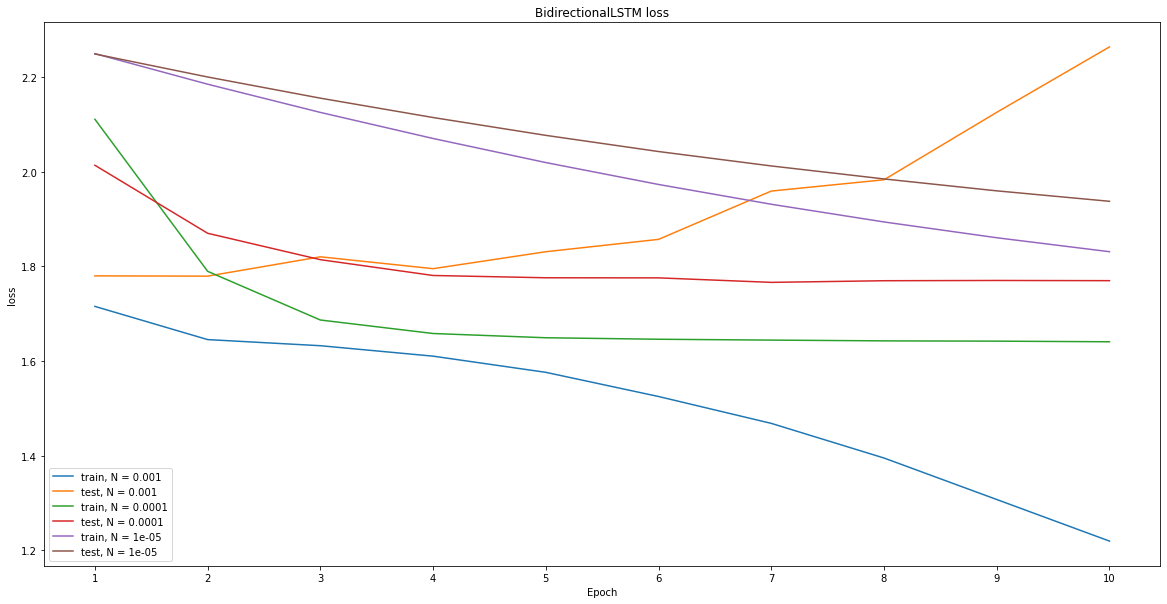

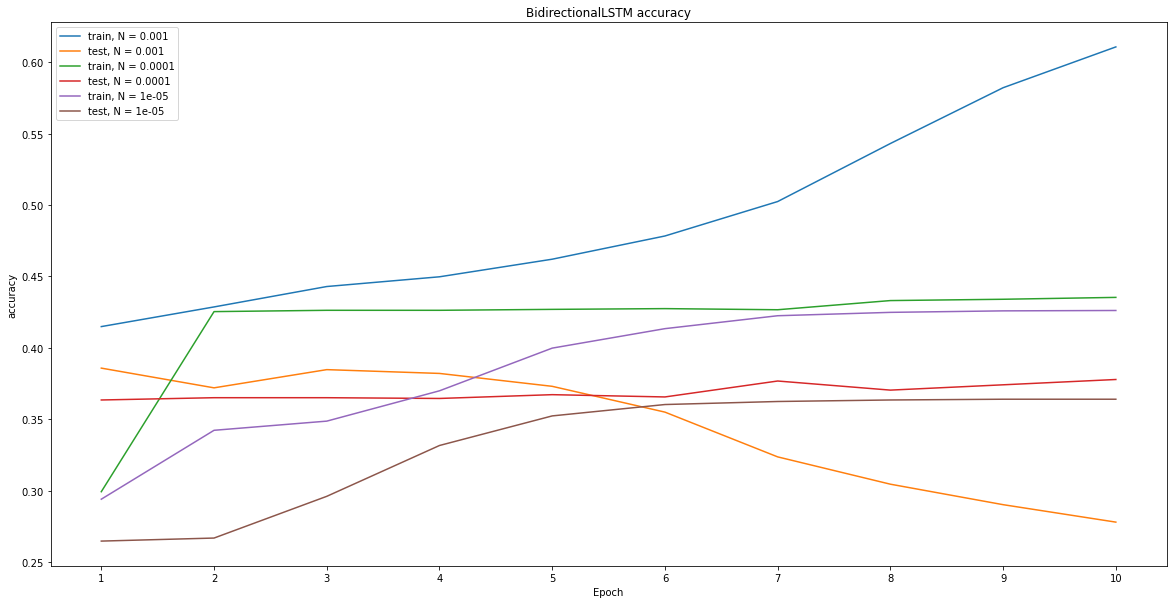

In [159]:
def draw_multiple(data, metrics, model):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()

    plt.title(f'{model} {metrics}')
    plt.xlabel('Epoch')
    plt.ylabel(metrics)

    max_epochs = len(data[0].history[metrics])+1
    x = range(1, max_epochs)
    plt.xticks(np.arange(1, max_epochs))

    for i, d in enumerate([0.001, 0.0001, 0.00001]):
        plt.plot(x, data[i].history[metrics], label=f'train, N = {d}')
        plt.plot(x, data[i].history[f'val_{metrics}'], label=f'test, N = {d}')
    plt.legend()
    plt.show()

draw_multiple(history, 'loss', 'BidirectionalLSTM')
draw_multiple(history, 'accuracy', 'BidirectionalLSTM')

# Wnioski

Zaimplementowano warstwę BidirectionalLSTM. 

Do badania wyników zastowowano architekturę i warstwy sieci LSTM z poprzedniego zadania. 
Wynikiem testów jest to, że sieć przeucza się na zbiorze treningowym, kiedy learning rate > 0.001, oraz osiąga max 36% acc na zbiorze testowym. kiedy learning rate < 0.001. Wprowadzenie warstwy Bidirectional LSTM nie polepszyło wyników, osiągniętych w poprzednim zadaniu.

In [129]:
history = []

for i in ['glove', 'fasttext', 'word2vec']:
    x_train = get_emb_data('train', i)
    y_train = get_y_data('train')

    x_test = get_emb_data('test', i)
    y_test = get_y_data('test')

    model = None
    model = tf.keras.Sequential([
        BidirectionalLSTM(32, 1),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.01),
                    metrics=['accuracy'])

    history.append(model.fit(np.expand_dims(x_train,1), np.expand_dims(y_train,1), epochs=10, validation_data=(np.expand_dims(x_test, 1), np.expand_dims(y_test,1)), batch_size=64))

Epoch 1/10
120/120 [==============================] - 2s 15ms/step - loss: 1.4257 - accuracy: 0.5516 - val_loss: 1.1864 - val_accuracy: 0.6334
Epoch 2/10
120/120 [==============================] - 1s 11ms/step - loss: 1.1181 - accuracy: 0.6396 - val_loss: 1.0136 - val_accuracy: 0.6913
Epoch 3/10
120/120 [==============================] - 1s 11ms/step - loss: 0.9599 - accuracy: 0.7060 - val_loss: 0.9503 - val_accuracy: 0.7067
Epoch 4/10
120/120 [==============================] - 1s 11ms/step - loss: 0.8546 - accuracy: 0.7487 - val_loss: 0.8486 - val_accuracy: 0.7614
Epoch 5/10
120/120 [==============================] - 1s 11ms/step - loss: 0.7726 - accuracy: 0.7778 - val_loss: 0.8090 - val_accuracy: 0.7662
Epoch 6/10
120/120 [==============================] - 1s 11ms/step - loss: 0.7244 - accuracy: 0.7948 - val_loss: 0.8728 - val_accuracy: 0.7455
Epoch 7/10
120/120 [==============================] - 1s 11ms/step - loss: 0.7023 - accuracy: 0.7991 - val_loss: 0.7574 - val_accuracy: 0.7976

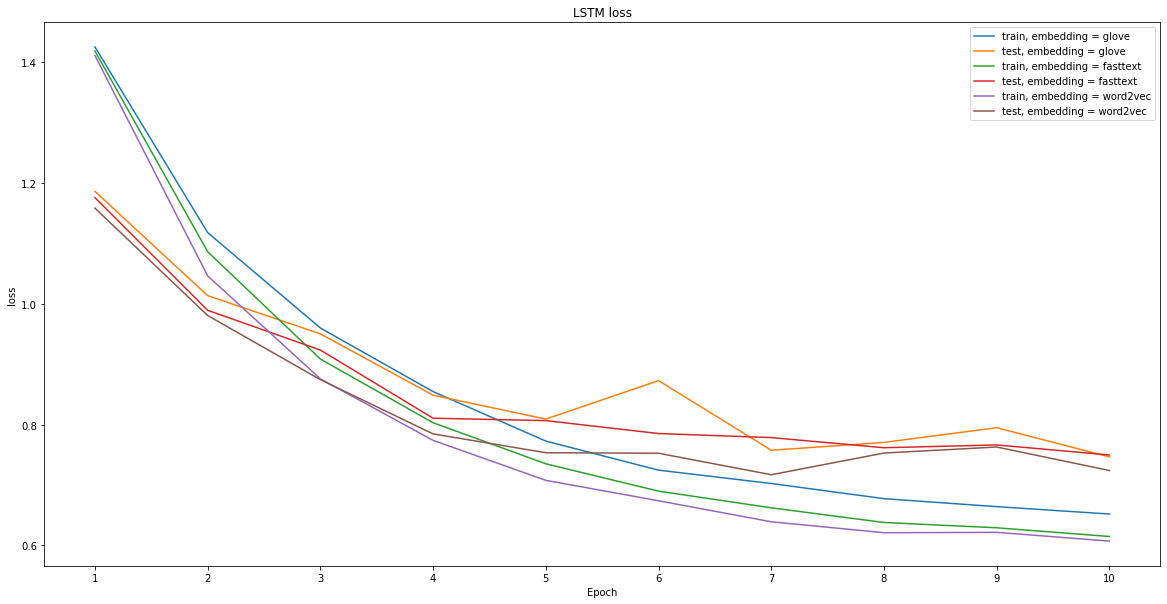

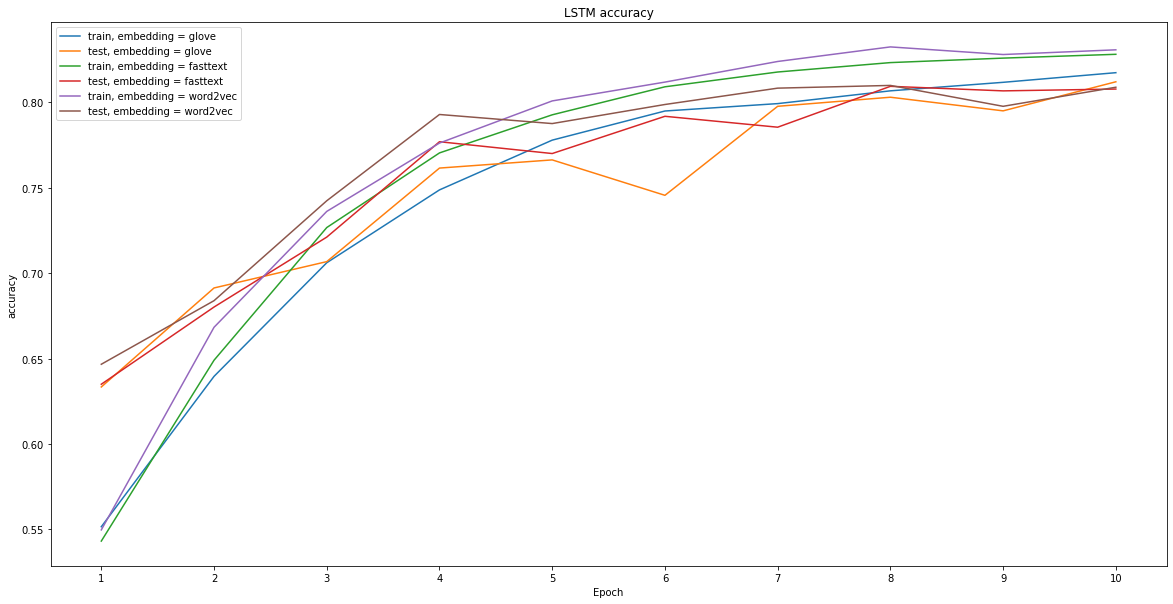

In [130]:
draw_multiple(history, 'loss', 'LSTM')
draw_multiple(history, 'accuracy', 'LSTM')

# Wnioski

Wyuczono 3 modele BidirectionalLSTM na zbiorze danych tensorflow.reuters, osadzonym wektorowo różnymi modelami: Glove, FastText i Word2Vec.

Na powyższych wykresach można zauważyć, że max wynik acc na zbiorze testowym osiągnęła sieć uczona na danych osadzonych wektorowo modelem Glove wynosi ~81.1%. Wyniki sieci FastText i Word2Vec są nieznacząco gorsze i wynoszą 80.8% i 80.9%. 

Wyniki funkcji straty nie wiele czym się różnią pomiędzy sieciami. Maksymalnie niski wynik osiągnęła sieć Word2Vec - 0.72 na zbiorze testowym. Wynik f. loss sieci uczonych na zbiorach Glove i Fasttext jest na poziomie 0.74.

W porównaniu do wyników sieci LSTM z poprzedniej listy zadań - miara acc jest ~2 razy większa, a loss - ~2 razy mniejsza. Biorąc pod uwagę to, że warstwa RNN nie została zmieniona w żaden sposób, można wywnioskować, że uczenie sieci na danych osadzonych wektorowo znacznie polepsza wyniki.